# Blood Sample Data

#### Importing Libraries

In [4]:
import time
start_time = int(time.time())
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential, Model
from keras.layers import *
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Using TensorFlow backend.
/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


#### Reading the Data

In [104]:
mimic=pd.read_csv('zevac_data.csv', sep='\t', usecols = ['patient_id', 'admission_id', 'age', 'sex', 'sc_date',
       'sample_type', 'bacteria_name', 'antibiotic_name', 'num_prev_adm',
       'interval', 'device', 'hai', 'susceptibility', 'comorbidity'])
mimic['susceptibility']=mimic['susceptibility'].replace({'I':'R'})
mimic['antibiotic_name']=mimic['antibiotic_name'].replace({'Tetracyclline':'Tetracycline', 'Penicillin G':'Penicillin'})

#### Getting Blood Sample Data

In [105]:
blood=mimic[mimic['sample_type']=='Blood'].reset_index(drop=True)

In [106]:
df=blood[['age', 'sex', 'num_prev_adm', 'interval', 'device', 
      'comorbidity', 'bacteria_name', 'antibiotic_name', 'susceptibility']]
df=df.drop_duplicates()
df=df.reset_index(drop=True)

#### Use Whole Data for Training

In [110]:
df.susceptibility.value_counts()

S    184263
R    102806
Name: susceptibility, dtype: int64

#### Shuffling Training Data

In [111]:
train = df.sample(frac=1).reset_index(drop=True)

#### Taking Out Target Column and Dropping Unnecesary Columns

In [112]:
train_labels = train['susceptibility']

In [113]:
df_train = train.drop("bacteria_name", 1)
df_train = df_train.drop("susceptibility", 1)
all_cols = df_train.columns
for col in all_cols:
    if df_train[col].nunique()<2:
        df_train = df_train.drop(col, 1)
all_cols = df_train.columns

In [114]:
len(all_cols)

7

#### Breaking Into 3 Types of Columns: Binary, Categorical and Other (Ordinal or Continous)

In [13]:
categorical_vars = [ ]
continuous_vars = [ ]
categorical_binary_vars = [ ]

for col in all_cols:
    if df_train[col].nunique()==2:
        categorical_binary_vars.append(col)
    else:
        if df_train[col].dtypes=='object':
            categorical_vars.append(col)
        else:
            continuous_vars.append(col)

In [14]:
print ("categorical binary vars: ", len(categorical_binary_vars))
print ("categorical non binary vars: ", len(categorical_vars))
print ("continuous vars: ", len(continuous_vars))

categorical binary vars:  1
categorical non binary vars:  3
continuous vars:  3


In [15]:
all_categorical_vars = categorical_binary_vars + categorical_vars
print ("all categorical vars: ", len(all_categorical_vars))

all categorical vars:  4


#### Displaying Number of Unique Values in Each Categorical Variable Column

In [16]:
for cat_var in all_categorical_vars:
    print (cat_var,":", df_train[cat_var].nunique())

sex : 2
device : 7
comorbidity : 19
antibiotic_name : 29


# Categorical Embedding

#### Printing Two Different Types of Variables Namely Categorical and Continuous/Ordinal

In [17]:
print(all_categorical_vars)
print(continuous_vars)

['sex', 'device', 'comorbidity', 'antibiotic_name']
['age', 'num_prev_adm', 'interval']


#### Preprocessing Training and Validation Data

In [18]:
def preprocessing(X_train):
    input_list_train = []
    #the cols to be embedded: rescaling to range [0, # values)
    for c in all_categorical_vars:
        vals = np.asarray(X_train[c].tolist())
        vals = pd.factorize(vals)[0]
        input_list_train.append(np.asarray(vals))
        """
        This below is another method to do this:
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        """
    #the rest of the columns
    input_list_train.append(X_train[continuous_vars].values)
    return input_list_train

In [20]:
df_tr_modified = preprocessing(df_train)

#### As Expected, The Proceesed Training DataFrame has 5 Elements Becasue We had 4 Categorical Columns and One for Other (Continous/Ordinal) Columns

In [21]:
len(df_tr_modified)

5

#### The Embedding Size is Set According to the Rule As Suggested by fast.ai Course and Entity Embedding Paper

Embedding_size  = integer value of min(ceiling(no of unique categories/2) , 50)

#### Each Model will be Appended to a List Named Models

In [22]:
%%html
<p style="color:red">Since Merge is Deprecated in Keras 2.2.2 We Shift to Functional API Rather Than Using Sequential Model</p>


In [23]:
models=[]
inputs=[]
embeddings=[]
functional_models=[]

In [24]:
%%html
<p style="color:red">Function to Convert Sequential Model to Functional API Model</p>


In [25]:
def get_functional(model):
    input_layer = Input(batch_shape=model.layers[0].input_shape)
    prev_layer = input_layer
    for layer in model.layers:
        prev_layer = layer(prev_layer)
    functional_model = keras.models.Model([input_layer], [prev_layer])
    return input_layer, prev_layer, functional_model

#### Following Code Adds an Embedding Network for Each of the Catgeoriacal Variables   

In [26]:
for variable in all_categorical_vars:
    print("For categorical column: ", variable)
    print("----------------------------------------------------------------------")
    model = Sequential()
    no_of_unique_categories  = df_train[variable].nunique()
    print("Number of unique categories: ",no_of_unique_categories)
    embedding_size = min(np.ceil(no_of_unique_categories/2), 50)
    embedding_size = int(embedding_size)
    print("Embedding size set as: ", embedding_size)
    model.add(Embedding(no_of_unique_categories+1, embedding_size, name=variable+'_embedding', input_length = 1))
    model.add(Reshape(target_shape=([embedding_size])))
    print(model.summary())
    input_layer, embedding, functional_model = get_functional(model)
    models.append(model)
    functional_models.append(functional_model)
    inputs.append(input_layer)
    embeddings.append(embedding)

For categorical column:  sex
----------------------------------------------------------------------
Number of unique categories:  2
Embedding size set as:  1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sex_embedding (Embedding)    (None, 1, 1)              3         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1)                 0         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
For categorical column:  device
----------------------------------------------------------------------
Number of unique categories:  7
Embedding size set as:  4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
device_embedding (Embedding) (None, 1, 4)              32        
______________________

#### Once the Embedding for Categorical Columns are Made, We Add Another Single Model for All the Continuous Variables and Add it to the Models List


In [27]:
model_rest = Sequential()
model_rest.add(Dense(16, input_shape = [3]))
model_rest.summary() 
input_layer_rest, embedding_rest, functional_model_rest = get_functional(model_rest)
models.append(model_rest)
functional_models.append(functional_model_rest)
inputs.append(input_layer_rest)
embeddings.append(embedding_rest)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                64        
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


#### Our Models List will Contain (Number of categorical variables)+1 Models, where Number of categorical variables = 4

In [28]:
models

In [29]:
functional_models

#### Finally We Merge All the Models Present into a Single Model Using Concat Method which Places the Models One After the Other


In [30]:
input_layer_full = Concatenate()(embeddings)

#### With Input Layers and Embedding Layers Done We can Build on Those as Any Other keras Functional Model.

Adding a few layers below

In [31]:
input_layer_full = Dense(128, activation='relu')(input_layer_full)
input_layer_full = Dropout(.5)(input_layer_full)
input_layer_full = Dense(64, activation='relu')(input_layer_full)
input_layer_full = Dropout(.25)(input_layer_full)
input_layer_full = Dense(32, activation='relu')(input_layer_full)
input_layer_full = Dropout(.15)(input_layer_full)
output = Dense(1, activation='sigmoid')(input_layer_full)

#### Creating the Full Model with All Variables

In [32]:
full_model = Model(inputs, output)

In [33]:
full_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
full_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
sex_embedd

#### Model Training

In [35]:
Y_train = train_labels.apply(lambda x: 1 if x=='S' else 0)

In [36]:
full_model.fit(df_tr_modified, Y_train)

Epoch 1/1
287511/287511 [==============================] - 25s 86us/step - loss: 0.5455 - acc: 0.7359


# Plotting Embeddings

#### Plot Categorical Embeddings with Categories>2

In [37]:
from sklearn import manifold
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [115]:
antibiotic_categories = df_train['antibiotic_name'].unique().tolist()
antibiotic_embedding = full_model.get_layer('antibiotic_name_embedding').get_weights()[0]
antibiotic_embedding

array([[ 0.11170086,  0.08140131, -0.02813517,  0.13444899,  0.08080621,
         0.08168409, -0.06918439,  0.09664609,  0.120297  , -0.06459768,
         0.12334897, -0.00569773,  0.06569877,  0.02201705, -0.0957703 ],
       [-0.33772478, -0.30546784,  0.28080183, -0.32252416, -0.31309298,
        -0.46251217,  0.28452346, -0.24300529, -0.26594576,  0.24785277,
        -0.47337365,  0.07908656, -0.26709956, -0.28585726,  0.20676054],
       [ 0.69034505,  0.6966545 , -0.68565017,  0.68511575,  0.62363845,
         0.83417386, -0.59925544,  0.5434557 ,  0.6708705 , -0.6437173 ,
         0.7674829 ,  0.44108602,  0.540782  ,  0.47166282, -0.5097972 ],
       [ 0.09621317,  0.08713031, -0.08605729,  0.11462221,  0.15168272,
         0.10354389, -0.04181318,  0.06697213,  0.1884936 , -0.08155961,
         0.12545504,  0.06161838, -0.04746003,  0.00715557, -0.09993888],
       [ 0.33242565,  0.34413865, -0.26967013,  0.40281528,  0.26336068,
         0.43708205, -0.22141658,  0.22839245, 

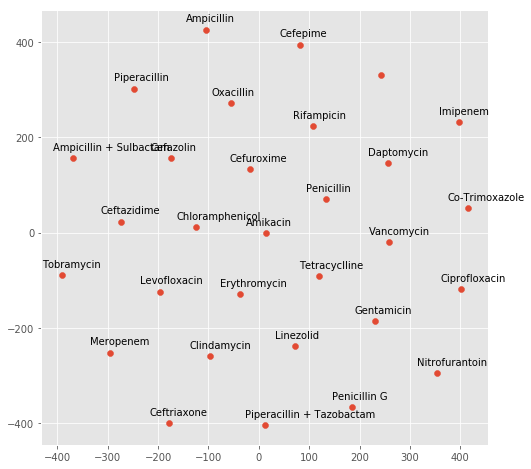

In [39]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(antibiotic_embedding)
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(antibiotic_categories):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')

In [40]:
device_categories = df_train['device'].unique().tolist()
device_embedding = full_model.get_layer('device_embedding').get_weights()[0]
device_embedding

array([[-0.09412102,  0.14440542, -0.29575822,  0.14517178],
       [-0.28722   ,  0.32550672, -0.4583388 ,  0.3910544 ],
       [ 0.20453262, -0.25443044,  0.32044658, -0.23938121],
       [ 0.5432626 , -0.6888523 ,  0.7383701 , -0.61014175],
       [ 0.33182338, -0.33671904,  0.44730008, -0.43722096],
       [-0.18189904,  0.15250021, -0.10953393,  0.1411932 ],
       [-0.4360597 ,  0.4486856 , -0.51741195,  0.43885124],
       [-0.04107539, -0.0109034 ,  0.0280715 , -0.03539417]],
      dtype=float32)

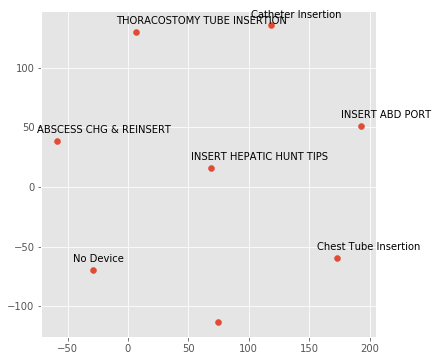

In [41]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(device_embedding)
plt.figure(figsize=(6,6))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(device_categories):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')

In [43]:
comorbidity_categories = df_train['comorbidity'].unique().tolist()
comorbidity_embedding = full_model.get_layer('comorbidity_embedding').get_weights()[0]
comorbidity_embedding

array([[ 0.03330209, -0.01178273, -0.01040587,  0.08123708, -0.08144718,
        -0.15675764,  0.02126415, -0.17812248,  0.00796809,  0.03087477],
       [-0.04338044, -0.08994757,  0.01531518,  0.01474336,  0.06290726,
         0.00853095,  0.03343017,  0.11597696,  0.05285592, -0.01308563],
       [-0.08924238,  0.08754957,  0.10189803, -0.20522854,  0.04159581,
         0.14584926, -0.27003002, -0.08121777, -0.1344262 , -0.06141409],
       [ 0.06588668,  0.07395311, -0.01852006,  0.00764013, -0.0318212 ,
        -0.08684915,  0.0829692 ,  0.0149933 , -0.03300434,  0.04220844],
       [-0.00693628, -0.03893401,  0.04850028,  0.01902612,  0.04172071,
        -0.1456838 ,  0.12567717,  0.00313758,  0.04689175,  0.05661589],
       [-0.01487413, -0.03909382, -0.17093848,  0.06824425,  0.06716458,
        -0.01505745,  0.13955916,  0.07730527,  0.1389404 ,  0.06184288],
       [-0.14966704, -0.20962478, -0.13243297,  0.21459779,  0.23811586,
        -0.19627032,  0.38397744,  0.07336276

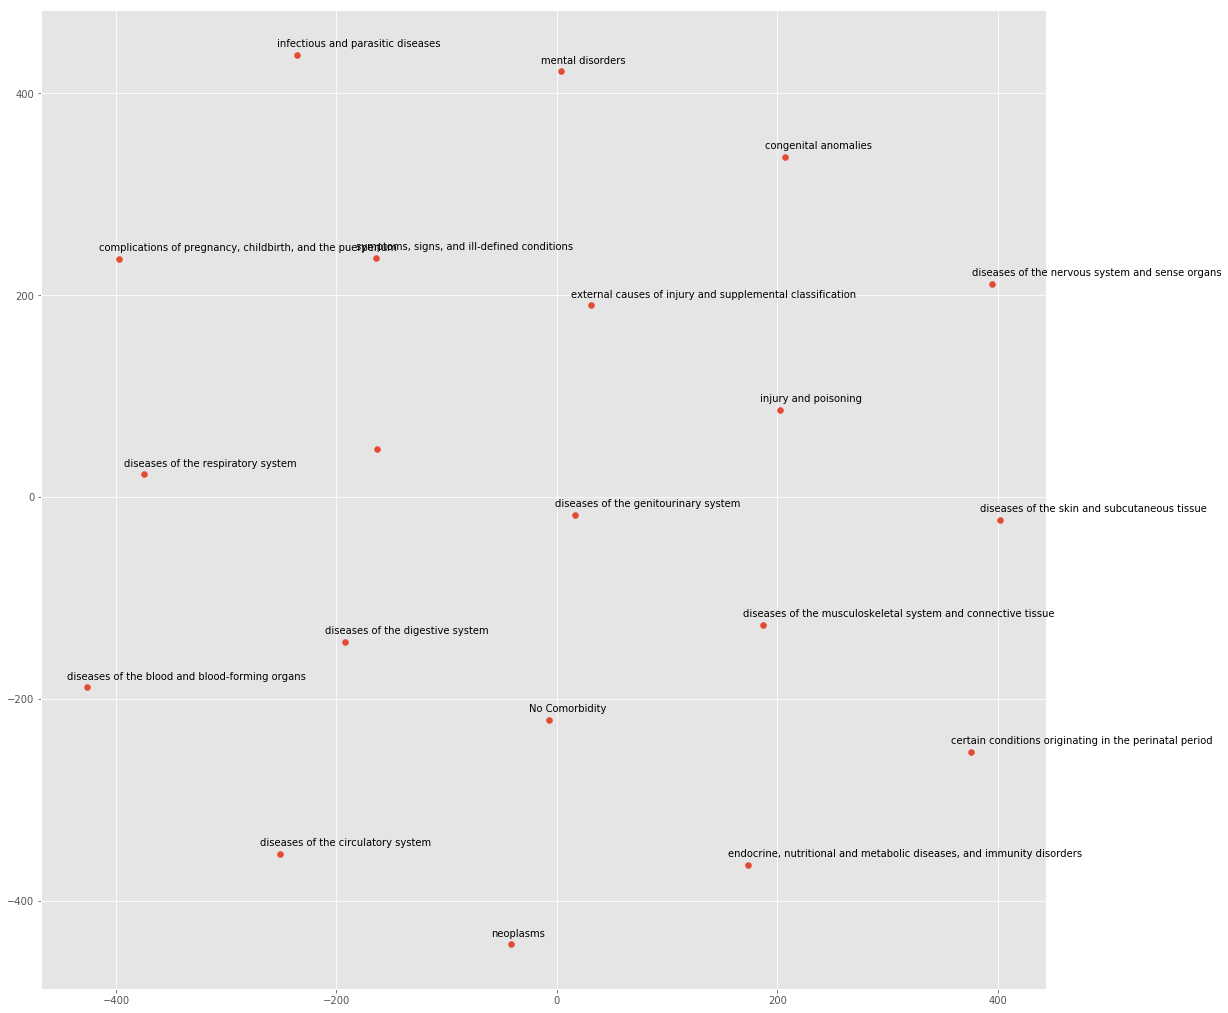

In [44]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(comorbidity_embedding)
plt.figure(figsize=(18,18))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(comorbidity_categories):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')

#### Plotting Pairwise Distances for Antibiotics (Embedding Vectors)

In [45]:
from scipy.spatial import distance
distances = pd.DataFrame(columns=['Antibiotic1', 'Antibiotic2', 'Distance'])
ab1=[]
ab2=[]
dist=[]
for i in range(len(antibiotic_categories)):
    for j in range(len(antibiotic_categories)):
        if j!=i:
            ab1.append(antibiotic_categories[i])
            ab2.append(antibiotic_categories[j])
            dist.append(distance.euclidean(antibiotic_embedding[i].reshape(-1, 1), antibiotic_embedding[j].reshape(-1, 1)))

distances['Antibiotic1'] = pd.Series(ab1)
distances['Antibiotic2'] = pd.Series(ab2)
distances['Distance'] = pd.Series(dist)
distances = distances.sort_values(by=['Distance']).reset_index(drop=True)
distances

,Antibiotic1,Antibiotic2,Distance
0,Ampicillin + Sulbactam,Ciprofloxacin,0.183492
1,Ciprofloxacin,Ampicillin + Sulbactam,0.183492
2,Ceftriaxone,Ceftazidime,0.195213
3,Ceftazidime,Ceftriaxone,0.195213
4,Nitrofurantoin,Cefepime,0.200905
5,Cefepime,Nitrofurantoin,0.200905
6,Cefepime,Co-Trimoxazole,0.206345
7,Co-Trimoxazole,Cefepime,0.206345
8,Rifampicin,Imipenem,0.213731
9,Imipenem,Rifampicin,0.213731


/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


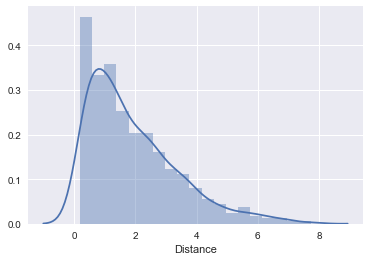

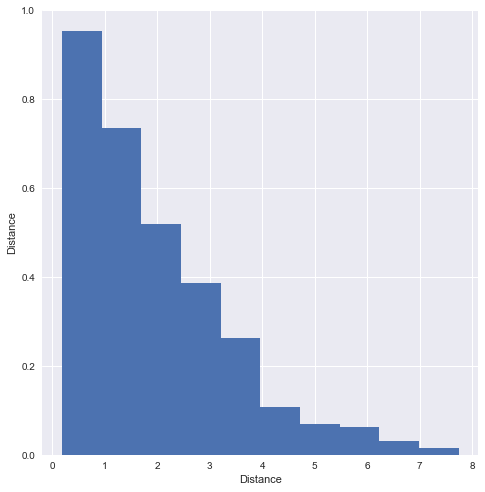

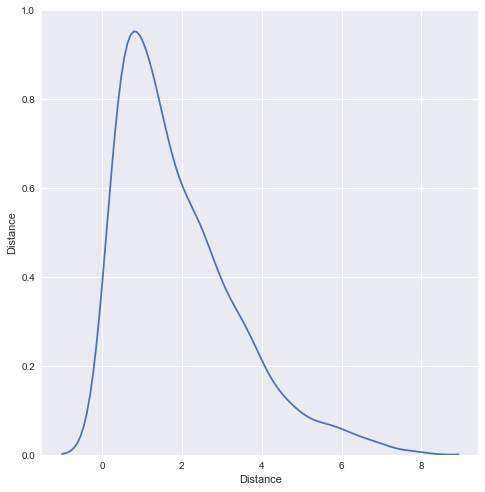

In [46]:
import seaborn as sns; sns.set(color_codes=True)
g = sns.distplot(distances.Distance)
g = sns.pairplot(distances, size=7)
g = sns.pairplot(distances, size=7, diag_kind='kde')

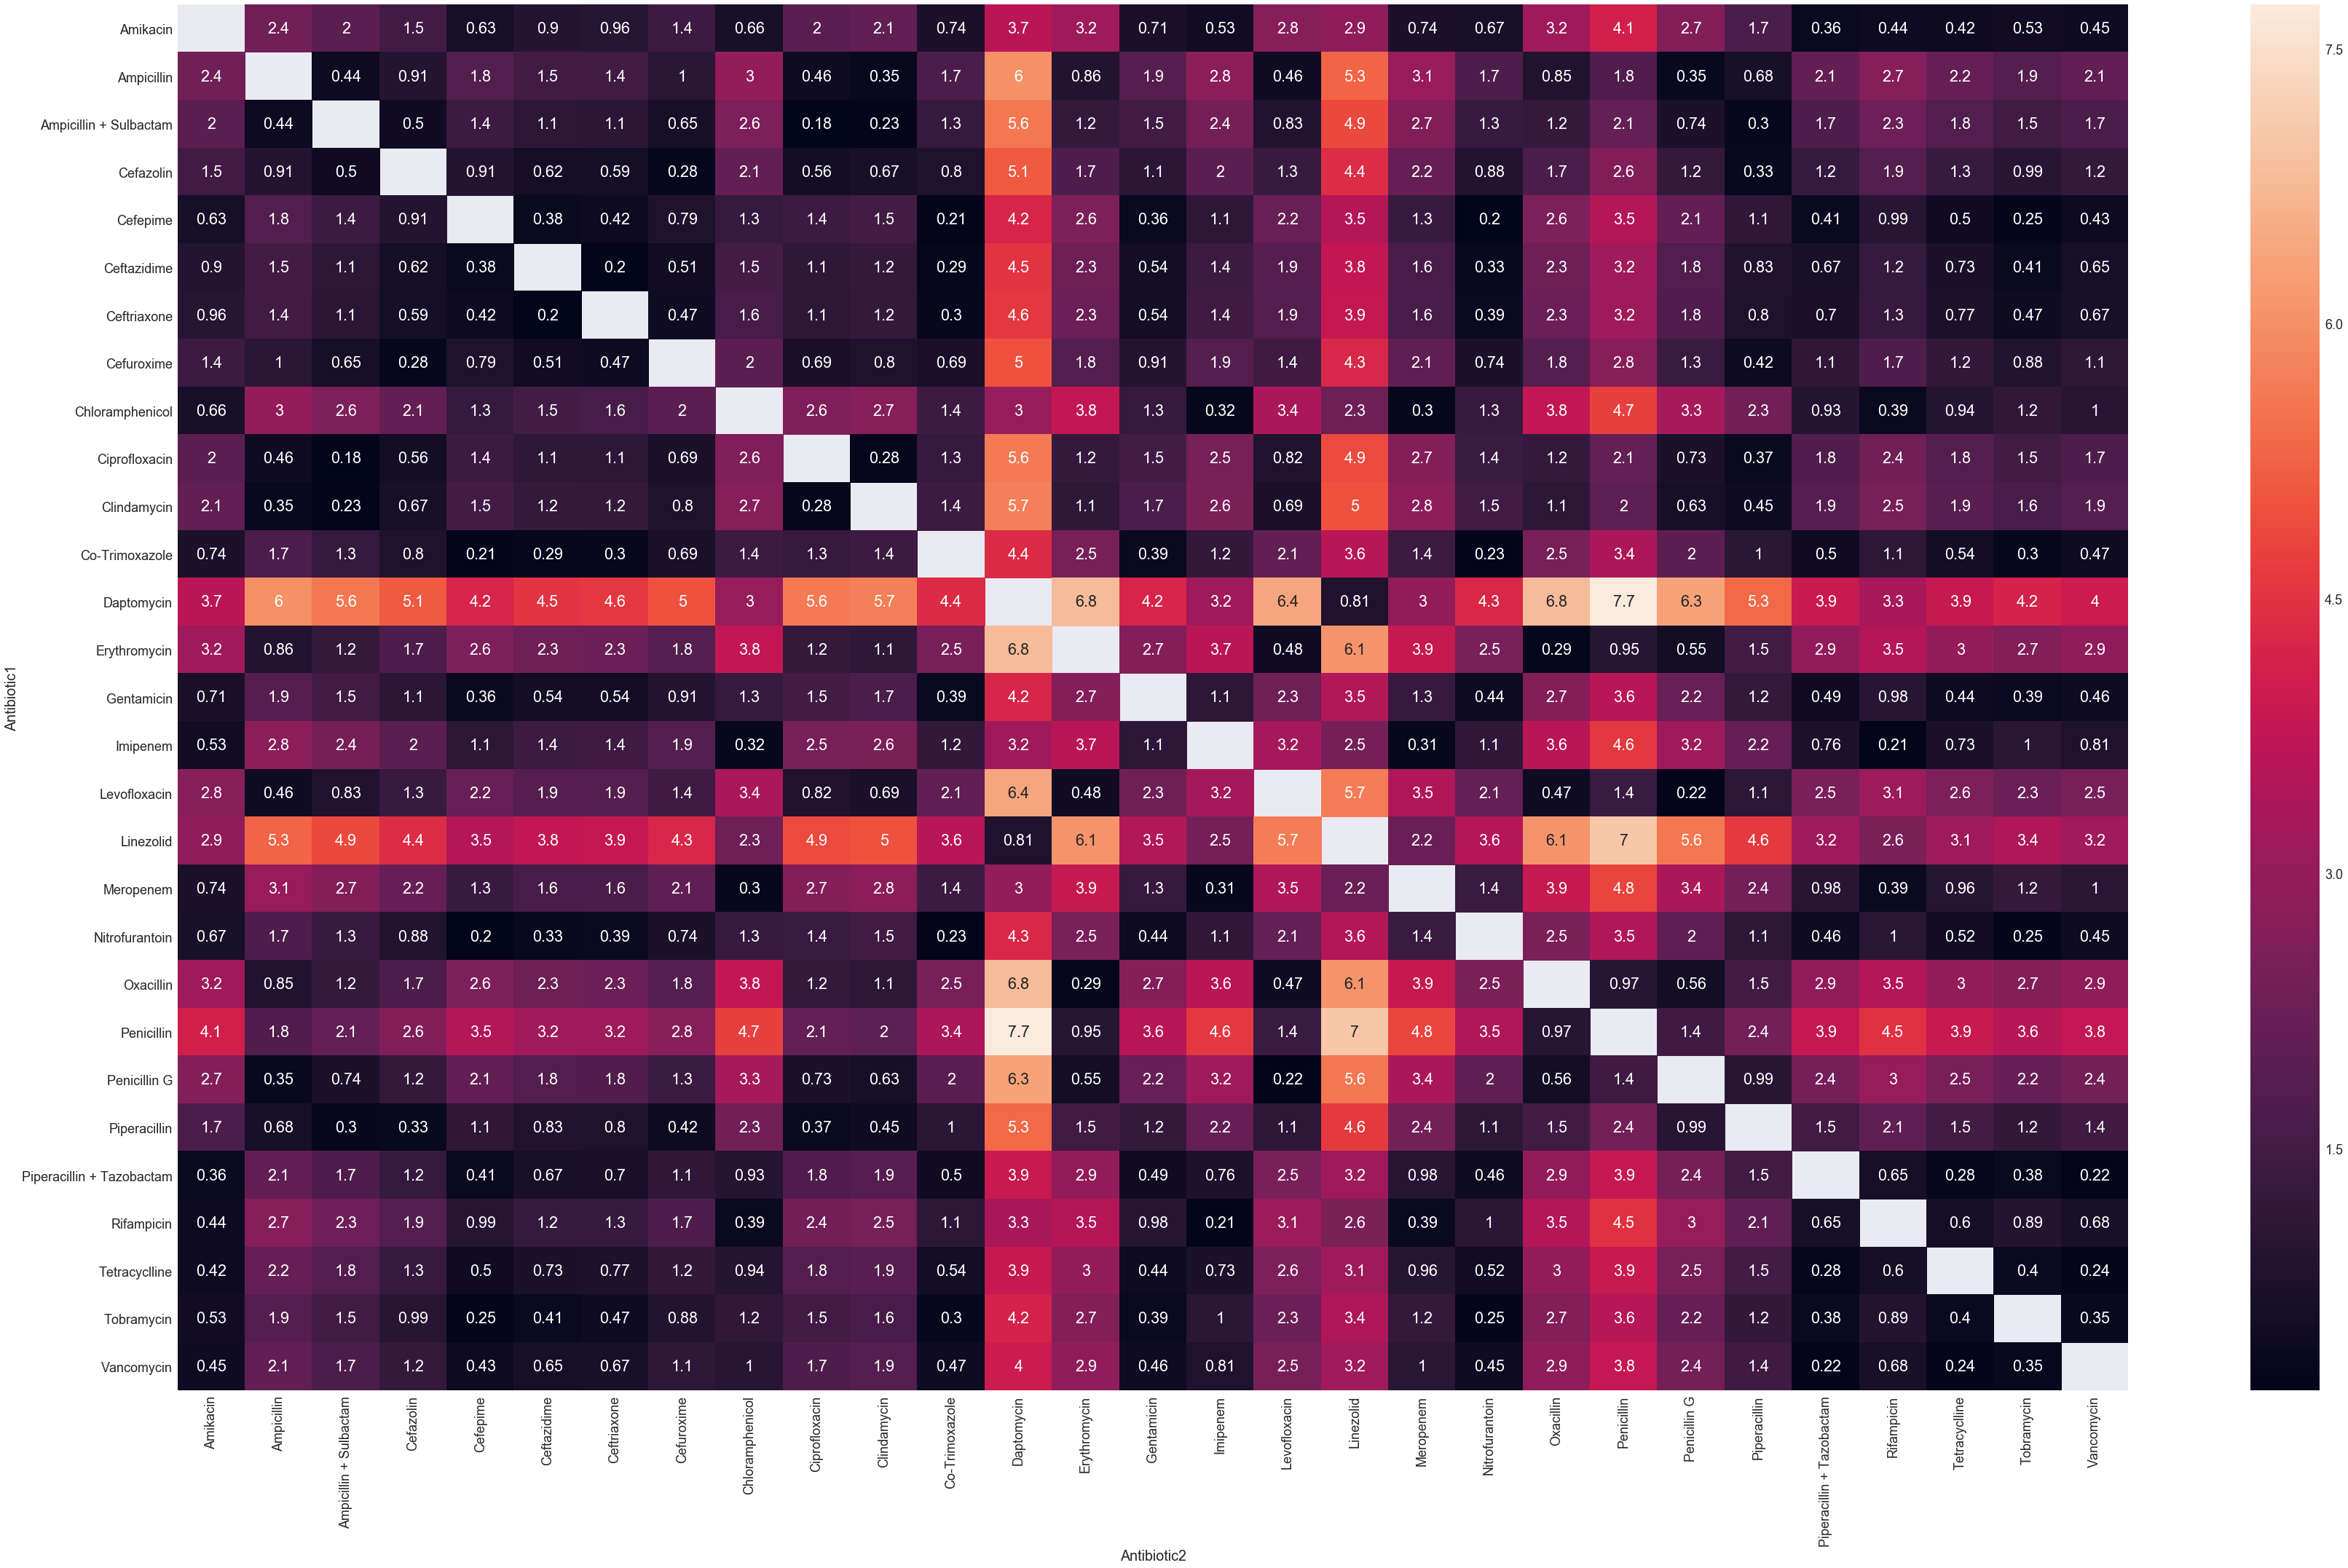

In [53]:
distances.Distance = distances.Distance.apply(lambda x: np.round(x, decimals=2))
plt.figure(figsize=(60, 35))
sns.set(font_scale=1.8) 
pivot = distances.pivot(index='Antibiotic1', columns='Antibiotic2', values='Distance')
ax = sns.heatmap(pivot,annot=True)
plt.show()

# Using As Pre-Trained Model on AIIMS Data

#### Freezing Problem Specific Layers

In [50]:
new_model = full_model
for layer in new_model.layers[:-7]:
    layer.trainable = False

In [51]:
for layer in new_model.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True


In [52]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
sex_embedd

/anaconda2/envs/py36/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


#### Compiling the New Model

In [ ]:
input_layer_full = Dense(128, activation='relu')(input_layer_full) ???????????????
input_layer_full = Dropout(.5)(input_layer_full)
input_layer_full = Dense(64, activation='relu')(input_layer_full)  ???????????????
input_layer_full = Dropout(.25)(input_layer_full)
input_layer_full = Dense(32, activation='relu')(input_layer_full)  ???????????????
input_layer_full = Dropout(.15)(input_layer_full)
output_new = Dense(1, activation='sigmoid')(input_layer_full)      ???????????????

In [ ]:
new_model = Model(inputs, output_new)                              ???????????????

In [139]:
new_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Creating Data for Training and Validation

In [83]:
aiims_data=pd.read_csv('/Users/deba_mycol/Zevac_Unified/zevac_unified/zevac_personalized_temp.csv', usecols=['slno', 'hosp_admission_id', 'hosp_patient_id', 'age',
       'sex', 'caretype', 'department', 'sc_date', 'sample_type',
       'comorbidity', 'bacteria_name', 'antibiotic_name', 'num_prev_adm',
       'interval', 'catheter', 'hai', 'susceptibility'])
aiims_blood = aiims_data[aiims_data.sample_type=='Blood']
aiims_blood = aiims_blood[aiims_blood.sex!='Others']
aiims_blood_icu = aiims_blood[aiims_blood.caretype=='ICU']


In [84]:
df_aiims=aiims_blood_icu[['age', 'sex', 'num_prev_adm', 'interval', 'catheter', 
      'comorbidity', 'bacteria_name', 'antibiotic_name', 'susceptibility']]
df_aiims=df_aiims.drop_duplicates()
df_aiims=df_aiims.reset_index(drop=True)

In [85]:
def get_device(catheter):
    if catheter=='YES':
        return 'Catheter Insertion'
    else:
        return 'No Device'
df_aiims['device'] = df_aiims['catheter'].apply(lambda x: get_device(x))

In [87]:
comorbidity_mapping = {
    'Cancer'                         :'neoplasms',
    'Liver Disease'                  :'diseases of the digestive system',
    'Pulmonary Disease'              :'diseases of the respiratory system',
    'No Comorbidity/Not Sure'        :'No Comorbidity',
    'Connective Tissue Disease'      :'diseases of the musculoskeletal system and connective tissue',
    'Diabetes'                       :'endocrine, nutritional and metabolic diseases, and immunity disorders',
    'Renal Disease'                  :'diseases of the genitourinary system', 
    'Cerebrovascular Disease or Tran':'diseases of the circulatory system',
    'Heart Disease'                  :'diseases of the circulatory system'
}
df_aiims['comorbidity'] = df_aiims['comorbidity'].replace(comorbidity_mapping)

In [108]:
print('Number of unique antibiotics in AIIMS ICU data:', len(df_aiims.antibiotic_name.unique()))
print('The Antibiotics are:\n', df_aiims.antibiotic_name.unique())

Number of unique antibiotics in AIIMS ICU data: 34
The Antibiotics are:
 ['Amikacin' 'Cefoperazone + Sulbactam' 'Cefotaxime' 'Ceftazidime'
 'Ciprofloxacin' 'Colistin' 'Co-Trimoxazole' 'Imipenem' 'Meropenem'
 'Piperacillin + Tazobactam' 'Erythromycin' 'Linezolid' 'Penicillin'
 'Teicoplanin' 'Vancomycin' 'Cefoxitin' 'Chloramphenicol' 'Clindamycin'
 'Netilmicin' 'Gentamicin (high level)' 'Amoxicillin + Clavulanic acid'
 'Tetracycline' 'Tigecycline' 'Levofloxacin' 'Amoxicillin' 'Ceftriaxone'
 'Ampicillin' 'Nitrofurantoin' 'Cefuroxime' 'Aztreonam' 'Cefixime'
 'Pristinamycin' 'Piperacillin' 'Cefepime']


In [116]:
print('Number of unique antibiotics in MIMIC data:', len(antibiotic_categories))
print('The Antibiotics are:\n', antibiotic_categories)

Number of unique antibiotics in MIMIC data: 28
The Antibiotics are:
 ['Erythromycin', 'Levofloxacin', 'Oxacillin', 'Co-Trimoxazole', 'Tobramycin', 'Piperacillin + Tazobactam', 'Clindamycin', 'Penicillin', 'Ampicillin + Sulbactam', 'Meropenem', 'Ciprofloxacin', 'Rifampicin', 'Gentamicin', 'Ampicillin', 'Ceftriaxone', 'Piperacillin', 'Vancomycin', 'Cefepime', 'Imipenem', 'Tetracycline', 'Cefazolin', 'Cefuroxime', 'Ceftazidime', 'Daptomycin', 'Amikacin', 'Linezolid', 'Chloramphenicol', 'Nitrofurantoin']


In [117]:
antibiotics = list(set(df_aiims.antibiotic_name.unique()) & set(antibiotic_categories))
print('Number of common antibiotics for ICU:', len(antibiotics))
print('The Antibiotics are:\n', antibiotics)

Number of common antibiotics for ICU: 21
The Antibiotics are:
 ['Piperacillin', 'Cefepime', 'Nitrofurantoin', 'Meropenem', 'Amikacin', 'Tetracycline', 'Ceftazidime', 'Cefuroxime', 'Vancomycin', 'Clindamycin', 'Levofloxacin', 'Erythromycin', 'Ciprofloxacin', 'Penicillin', 'Chloramphenicol', 'Piperacillin + Tazobactam', 'Ampicillin', 'Linezolid', 'Ceftriaxone', 'Imipenem', 'Co-Trimoxazole']


In [118]:
print('Antibiotics only in AIIMS ICU:\n', set(df_aiims.antibiotic_name.unique()).difference(antibiotic_categories))
print('Antibiotics only in MIMIC:\n', set(antibiotic_categories).difference(df_aiims.antibiotic_name.unique()))

Antibiotics only in AIIMS ICU:
 {'Cefixime', 'Gentamicin (high level)', 'Cefotaxime', 'Cefoxitin', 'Pristinamycin', 'Amoxicillin', 'Aztreonam', 'Tigecycline', 'Cefoperazone + Sulbactam', 'Teicoplanin', 'Colistin', 'Netilmicin', 'Amoxicillin + Clavulanic acid'}
Antibiotics only in MIMIC:
 {'Cefazolin', 'Rifampicin', 'Oxacillin', 'Daptomycin', 'Gentamicin', 'Tobramycin', 'Ampicillin + Sulbactam'}


In [127]:
df_aiims = df_aiims[df_aiims.antibiotic_name.isin(antibiotics)].reset_index(drop=True)
df_aiims = df_aiims[['age', 'sex', 'num_prev_adm', 'interval', 'device', 'comorbidity',
       'bacteria_name', 'antibiotic_name', 'susceptibility']]

In [128]:
df_aiims = df_aiims.sample(frac=1).reset_index(drop=True)

In [129]:
train_labels = df_aiims['susceptibility']

In [130]:
df_aiims = df_aiims.drop("bacteria_name", 1)
df_aiims = df_aiims.drop("susceptibility", 1)

In [132]:
df_tr = df_aiims[:3000]
df_val = df_aiims[3000:]

In [141]:
Y_train  = train_labels[:3000]
Y_val  = train_labels[3000:]
Y_train = Y_train.apply(lambda x: 1 if x=='S' else 0)
Y_val = Y_val.apply(lambda x: 1 if x=='S' else 0)

In [137]:
df_tr_modified = preprocessing(df_tr)
df_val_modified = preprocessing(df_val)

#### New Model Training

In [142]:
new_model.fit(df_tr_modified, Y_train)

Epoch 1/1
3000/3000 [==============================] - 1s 217us/step - loss: 0.7515 - acc: 0.5070


#### New Model Evaluation

In [143]:
new_model.evaluate(df_val_modified, Y_val)

2473/2473 [==============================] - 0s 86us/step


[0.7198841990703424, 0.40396279822681]